# Cat-Dog Image Classifier with Transfer Learning

In this notebook, I'll build a powerful image classifier using transfer learning with pre-trained neural networks. The main goal is to leverage the knowledge learned by networks trained on the extensive ImageNet dataset to achieve impressive accuracy in distinguishing between cat and dog images.

## Project Overview

### 1. Loading Essentials
   - Importing crucial PyTorch libraries for the project.
   - Defining the path to my cat and dog image dataset.
   - Setting up data transformations for effective training and testing.

### 2. Utilizing Pre-trained Models
   - Exploring the capabilities of `torchvision.models` to access pre-trained networks.
   - Loading a pre-trained ResNet50 model to serve as the foundation.

### 3. Customizing and Training the Classifier
   - Modifying the pre-trained ResNet50 model to suit the specific cat and dog classification task.
   - Freezing parameters to retain the pre-trained knowledge.
   - Setting up the loss function, optimizer, and initiating the training process.

### 4. Training the Classifier (Output Layer)
   - Specifying the number of epochs and defining key training parameters.
   - Iterating through epochs to train the network.
   - Evaluating the model's performance on the test set.

### 5. Plotting Train & Test Loss
   - Visualizing the training and validation loss over epochs for insights.

### 6. Inference
   - Testing the trained network on a subset of the test data to ensure robust performance.

### 7. Visualization of Predictions
   - Developing a function to visually assess model predictions.
   - Displaying predictions for five handpicked images from the test dataset.

---------------

## Load Data

After loading in the data from the 'train' and 'test' folders, the subsequent steps involve setting up image transformations. For the training data, these transformations include random rotation, resizing, and horizontal flipping. These augmentations help the model generalize better by exposing it to a variety of perspectives and orientations of the images during training. Additionally, normalization is applied to ensure that the pixel values of the images are within a certain standardized range, making it easier for the neural network to learn effectively.

For the testing data, fewer augmentations are applied, such as resizing and center cropping, as the model should be evaluated on the original, unaltered images. Finally, the code loads the transformed data into data loaders, which are essential for efficiently feeding batches of images to the neural network during the training and evaluation phases. Data loaders enhance training speed and memory efficiency, making the overall machine learning process more effective.

In [15]:
# Load libraries
import torch
from torchvision import datasets, transforms

# Define path to data
data_dir = 'Cat_Dog_data'

# Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       # to match the normalization used when the models were trained
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225]) 
                                                            ])

# No Data Augmentation for test data
test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor()])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

### Load a Pre-Trained Model  

The code first imports the necessary components, including a pre-trained deep learning model, specifically ResNet50. The model is loaded with its default weights, allowing it to recognize and classify features in the cat and dog images without the need for extensive training. By using a pre-trained model, I can benefit from the knowledge it gained during its initial training on a diverse dataset, making it a powerful tool for our specific task of cat and dog image classification.

*Note:* To leverage GPU acceleration if available, the code dynamically sets the computing device to "cuda" (GPU) or "cpu" based on the system's capabilities.

In [16]:
## Using a pretrained model (e.g., resnet50 or densenet121) to classify the cat and dog images
from torchvision.models import resnet50, ResNet50_Weights

# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a pre-trained network
model = resnet50(weights=ResNet50_Weights.DEFAULT) #model = resnet50(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**Comment:**  
The model summary show that the final output/classifier layer is called "fc" ('fully connected'). This is the layer I will not update to my specifc classification case. I also see that a total of 2048 features are fed into this final layer. Hence, the new classifier I will define, should take the same number of features as input.

### Define New Classifier  

Here, I am fine-tuning the previously loaded ResNet50 model for the specific task of classifying cat and dog images. The libraries for neural network operations and optimization are imported from PyTorch. To avoid backpropagation through the pre-trained layers of the model, their parameters are frozen.

A new classifier is created and attached to the model. This classifier consists of a sequential neural network, including a fully connected layer with 512 neurons, ReLU activation function, dropout regularization, another fully connected layer with 2 neurons (representing the two classes: cats and dogs), and a LogSoftmax activation function to obtain probabilities. This modification allows the model to adapt to our specific classification needs.

The Negative Log Likelihood Loss function is set as the criterion, which measures the difference between predicted and actual class probabilities. Only the parameters of the newly added classifier are optimized during training, while the parameters of the pre-trained layers remain fixed. The Adam optimizer is used with a learning rate of 0.003 to update the classifier's parameters.

Finally, the model is moved to the specified computing device (GPU if available) for accelerated training. This process of fine-tuning the pre-trained model enables it to learn the nuances of our cat and dog dataset while retaining the valuable features it gained from its initial training on a diverse dataset.

In [17]:
# Load the libraries
from torch import nn, optim
from torchvision import models
import torch.nn.functional as F

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
# Create a new classifier that fits our data (use model.NAME-OF-LAST-LAYER, here "fc")
model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 512),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(512, 2), # two classes (cats and dogs)
                            nn.LogSoftmax(dim=1))

# Set criterion to the Negative Log Likelihood Loss function
criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen & (use model.NAME-OF-LAST-LAYER, here "fc")
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

model.to(device);

### Re-Train Classifier (Output-Layer)  

Next, I am retraining the final output layer of the previously modified ResNet50 model (given that I froze the other parameters above) for a specified number of epochs (30 in this case) to improve its ability to classify cat and dog images. The training process involves iterating through the training dataset, computing the loss, and updating the model parameters using backpropagation. The code also monitors the model's performance on the test dataset, evaluating both loss and accuracy.

During each epoch, the total training loss is calculated and updated as the model processes each batch of training images. The optimizer minimizes this loss, adjusting the weights of the added classifier. The code prints information about the training progress, including the running training loss and the mean test loss and accuracy at regular intervals specified by the `print_every` variable.

The model is switched to evaluation mode before testing, disabling dropout to obtain more accurate predictions. The test loss and accuracy are computed similarly to the training phase, and the results are printed at the end of each epoch. The training and test losses are then appended to their respective lists for later analysis. This iterative training process aims to enhance the model's ability to correctly classify cat and dog images over multiple epochs.

In [18]:
# Set the number of epochs to train for
epochs = 30

steps = 0
running_loss = 0
print_every = 5

# Initialize lists to monitor test/train loss and accuracy
train_losses, test_losses = [], []

# Train the network and monitor performance in terms of loss and accuracy on the test set
for epoch in range(epochs):
    # monitor training loss
    tot_train_loss = 0.0

    ###################
    # train the model #
    ###################
    for images, labels in trainloader:
        # Increment steps every epoch
        steps += 1
        # Move images and label tensors to the default device
        images, labels = images.to(device), labels.to(device)
        # Get log-probabilities from model
        log_ps = model.forward(images)
        # Calculate the loss
        loss_train = criterion(log_ps, labels)

        # Clear gradients in each epoch
        optimizer.zero_grad()
        # Update total train loss after each image
        tot_train_loss += loss_train.item()
        # Backpropagate the gradients
        loss_train.backward()
        # Update the weights based on the gradients
        optimizer.step()

        # Update running loss to enable comparison between train and test sets
        running_loss += loss_train.item()

    ###################
    # test the model #
    ###################   
    if steps % print_every == 0:
        tot_test_loss = 0
        accuracy = 0  # Number of correct predictions on the test set
        model.eval() # This sets the model to evaluation mode where the dropout probability is 0.
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                # Move images and label tensors to the default device
                images, labels = images.to(device), labels.to(device)
                # Get log-probabilities from model
                log_ps = model.forward(images)
                # Calculate the loss (for every batch)
                loss_test = criterion(log_ps, labels)
                # Update total test loss after each image
                tot_test_loss += loss_test.item()
                # Get the class probabilities (Output of the network are log-probabilities, need to take exponential for probabilities)
                ps = torch.exp(log_ps)
                # Get the predicted most likely class (The class with the highest probability)
                top_p, top_class = ps.topk(1, dim=1)
                # Compare the predicted class to the actual class
                equals = top_class == labels.view(*top_class.shape)
                # Calculate the accuracy of predictions
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        # Get mean loss to enable comparison between train and test sets
        train_loss = tot_train_loss / len(trainloader.dataset)
        test_loss = tot_test_loss / len(testloader.dataset)

        # At completion of epoch append mean loss to lists
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        # Print out information on performance at end of epoch
        print(f"Epoch {epoch+1}/{epochs}.. "
              f"Train loss: {running_loss/print_every:.3f}.. " #  Train loss is runnig loss for the last {print_every} steps
              f"Test loss: {test_loss/len(testloader):.3f}.. " # Get mean loss to enable comparison between train and test sets
              f"Test accuracy: {accuracy/len(testloader):.3f}")
        
        running_loss = 0
        model.train()

Epoch 5/30.. Train loss: 51.808.. Test loss: 0.000.. Test accuracy: 0.968
Epoch 10/30.. Train loss: 45.868.. Test loss: 0.000.. Test accuracy: 0.954
Epoch 15/30.. Train loss: 43.213.. Test loss: 0.000.. Test accuracy: 0.968
Epoch 20/30.. Train loss: 42.888.. Test loss: 0.000.. Test accuracy: 0.961
Epoch 25/30.. Train loss: 41.751.. Test loss: 0.000.. Test accuracy: 0.952
Epoch 30/30.. Train loss: 40.730.. Test loss: 0.000.. Test accuracy: 0.952


### Plot Train & Test Loss over Epochs  

This code, which uses the `%matplotlib inline` and `%config InlineBackend.figure_format = 'retina'` magic commands to display plots inline in a Jupyter notebook, utilizes the `matplotlib` library to visualize the training and validation (test) losses during the training process. It plots the training loss and validation loss on the same graph, providing a visual representation of how well the model is learning from the training data and generalizing to new, unseen data.

The x-axis typically represents the number of epochs, and the y-axis represents the loss. The training loss curve shows how well the model is fitting the training data over epochs, while the validation loss curve indicates how well the model is performing on new, unseen data. The presence of both curves on the same plot allows for a quick comparison of their trends. If the training loss continues to decrease while the validation loss starts to increase, it could indicate overfitting, where the model is becoming too specialized to the training data.

The absence of overfitting is generally observed when both curves decrease and stabilize or follow similar trends. This plot serves as a useful tool for assessing the model's learning progress and generalization capabilities during the training process.

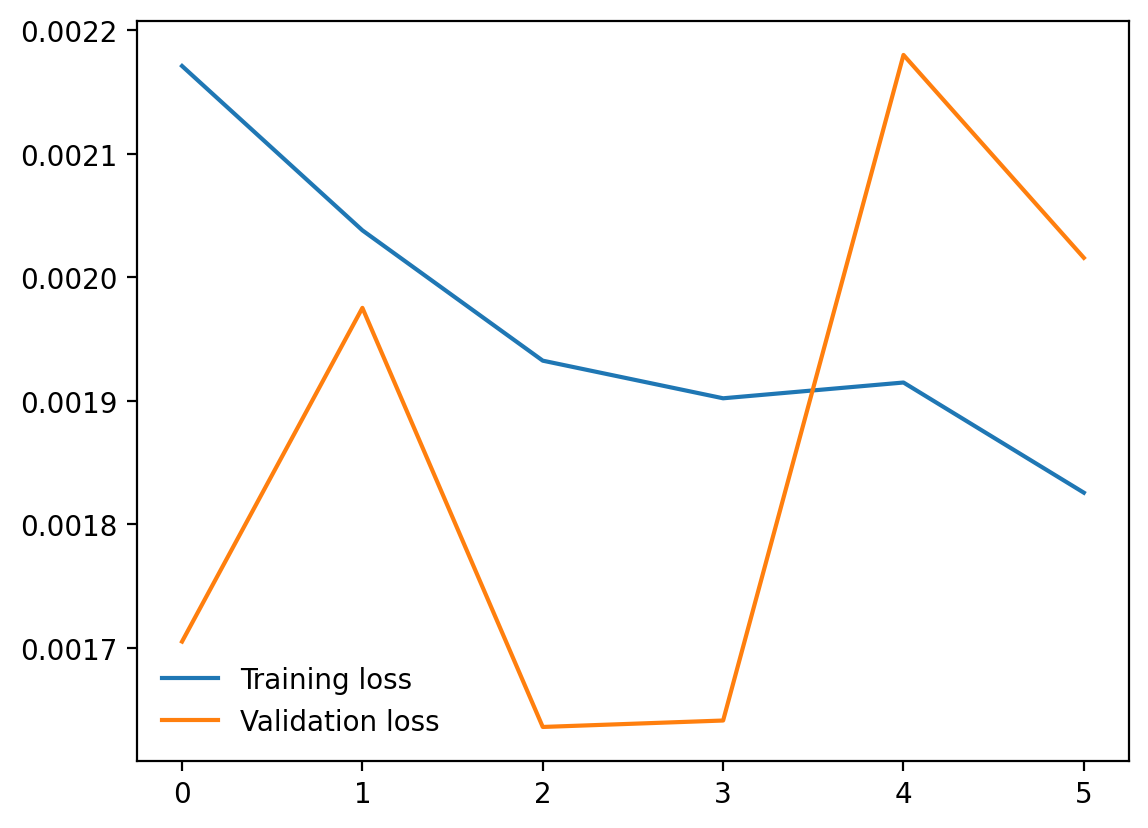

In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

### Inference

**1) Get predicitions from network on test data.**

In this code snippet, the trained ResNet50 model is put into evaluation mode using `model.eval()`. An iterator is then created from the test data loader, and the first batch of images and labels is obtained using `next(dataiter)`. The code selects the first image from the batch and prepares it for testing.

The image is reshaped into a 3D tensor and moved to the same device (GPU or CPU) as the model. The forward pass is then performed on this single image, calculating the class probabilities using the softmax function. The resulting probabilities are stored in the `ps` variable after being transformed back to the CPU for further analysis or visualization.

This code allows you to test the trained model on a single image from the test dataset and obtain the model's predicted class probabilities. It is a common practice to use a small batch or even a single image for testing to observe the model's behavior on individual samples.

In [20]:
# Test out your network!
model.eval()

dataiter = iter(testloader)
images, labels = next(dataiter) # The .next() operation was removed in this PR 12 as it’s Python 2 syntax according to PEP 3114 2 so use the next(iterator) call. [https://discuss.pytorch.org/t/dataloader-has-no-attribute-dataset/146623/9]
img = images[0]

# Convert 2D image to 3D tensor and move it to the same device as the model
img = img.view(1, 3, 224, 224).to(device)  # Assuming RGB images with size 224x224

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

# Move the output tensor to CPU before converting to NumPy array
ps = torch.exp(output)
ps = ps.to(device)

**2) Define function to visulize images and predicted label/class.** 

Here, I've defined a function named `view_classify` using `matplotlib` and `numpy` for visualization. This function takes an image (`img`) and its predicted class probabilities (`ps`) as inputs and displays them side by side. Firstly, it converts the PyTorch tensors to Numpy arrays for easier handling. Then, it creates a subplot with two columns: the first column displays the input image, and the second column shows a horizontal bar chart representing the predicted class probabilities. The y-axis of the bar chart is labeled with the class indices ('cat' and 'dog'), and the bar widths correspond to the predicted probabilities. This function is designed to aid in visually assessing the model's confidence in its predictions for a given image.

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image along with its predicted probabilities
def view_classify(img, ps, version="MNIST"):
    # Convert to numpy array and remove single-dimensional entries from the shape of an array
    ps = ps.cpu().numpy().squeeze() 
    img = img.cpu().numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6, 9), ncols=2)
    ax1.imshow(np.transpose(img, (1, 2, 0)))  # Use np.transpose instead of permute
    ax1.axis('off')
    ax2.barh(np.arange(len(ps)), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(len(ps)))
    ax2.set_yticklabels(np.arange(len(ps)))
    # Set y-axis labels to 'cat' and 'dog'
    ax2.set_yticklabels(['cat', 'dog'])
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

**3) Visualize image and predicted label/class for 5 exemplary images.**  

Finally, I'm iterating through the test dataset and predicting the class for five exemplary images using the trained model. For each image, I move it and its corresponding label to the same device as the model (either GPU or CPU). I convert the 2D image to a 3D tensor, assuming it's an RGB image with a size of 224x224 pixels.

Next, I use the model to calculate the class probabilities (softmax) for the image. The actual class is obtained from the ground truth labels, where 0 represents 'cat' and 1 represents 'dog'. Finally, I visualize the result for the current image using the `view_classify` function, displaying the image alongside its predicted class probabilities. This process is repeated for five exemplary images, providing a visual assessment of how well the model is performing on the test dataset.

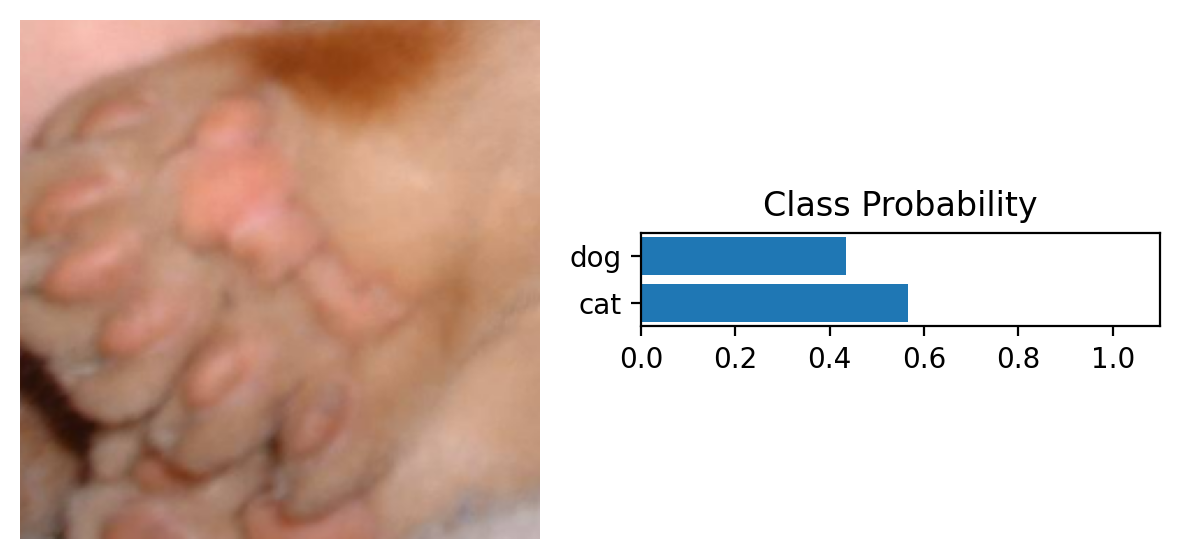

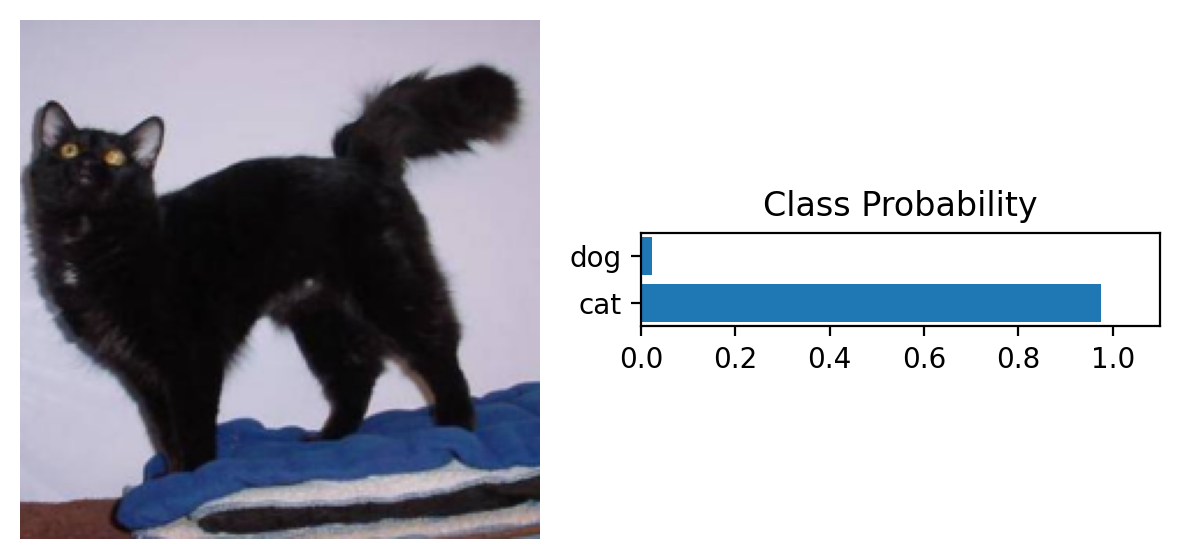

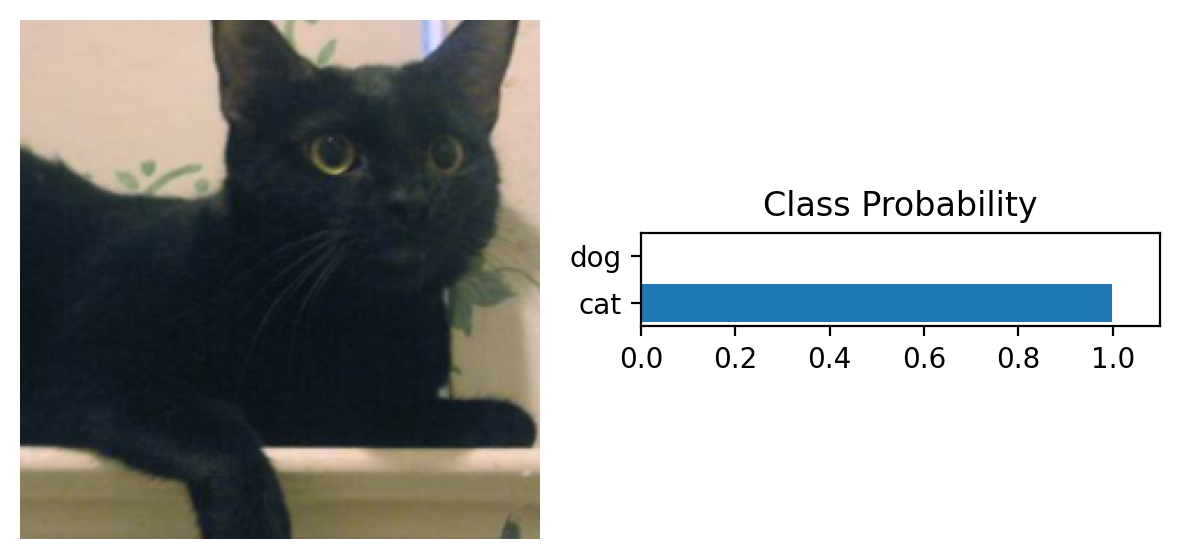

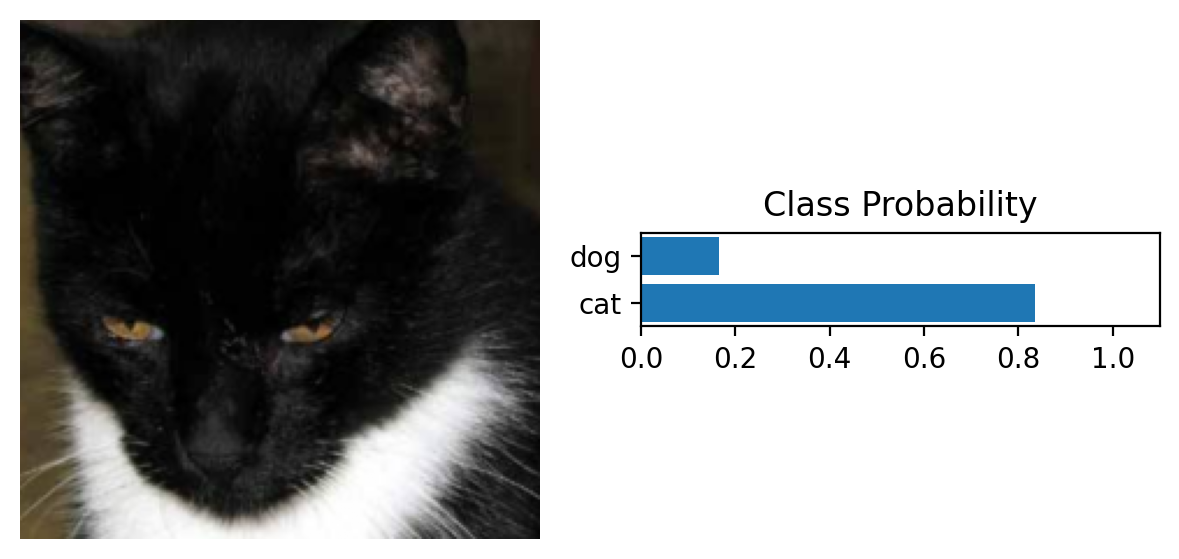

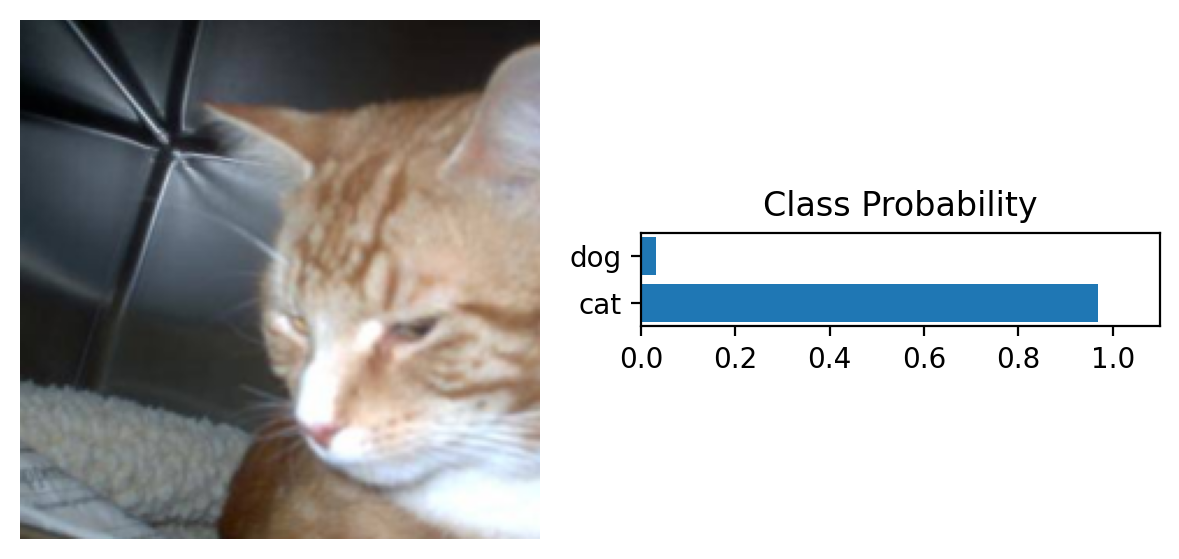

In [22]:
# Loop through the test dataset and predict class for five exemplary images
for _ in range(5):
    images, labels = next(dataiter)
    
    # Move images and labels to the same device as the model
    images, labels = images.to(device), labels.to(device)

    # Convert 2D image to 3D tensor
    img = images[0].view(1, 3, 224, 224)  # Assuming RGB images with size 224x224
    img = img.to(device)

    # Calculate the class probabilities (softmax) for img
    with torch.no_grad():
        output = model.forward(img)

    # Get the actual class (0 for 'cat', 1 for 'dog')
    actual_class = labels[0].item()

    # Visualize the result for the current image
    view_classify(images[0], torch.exp(output), actual_class)
    plt.show()